In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



# Imported Libraries

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import collections

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import itertools

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV



df = pd.read_csv('creditcardcomplete.csv')
df.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# pip install xgboost


In [3]:

# pip install tensorflow

In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [5]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [6]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [     0      1      2 ... 284802 284803 284805] Test: [    21     23     25 ... 284799 284804 284806]
Train: [     1      2      6 ... 284803 284804 284806] Test: [     0      3      4 ... 284795 284801 284805]
Train: [     0      1      2 ... 284804 284805 284806] Test: [     6      7     16 ... 284796 284797 284803]
Train: [     0      2      3 ... 284804 284805 284806] Test: [     1     10     17 ... 284776 284785 284802]
Train: [     0      1      3 ... 284804 284805 284806] Test: [     2      8      9 ... 284787 284793 284800]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def plot_confusion_matrx(original_ytest,fraud_predictions, name = " "):
    oversample_smote = confusion_matrix(original_ytest, fraud_predictions)
    actual_cm = confusion_matrix(original_ytest, original_ytest)
    labels = ['No Fraud', 'Fraud']

    fig = plt.figure(figsize=(16,8))

    fig.add_subplot(221)
    plot_confusion_matrix(oversample_smote, labels, title="No Sampling "+name+"\n Confusion Matrix", cmap=plt.cm.Oranges)

    fig.add_subplot(222)
    plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (Ideal Case)", cmap=plt.cm.Greens)

In [10]:
def tune_the_estimator(estimator, params,Xsm_train,ysm_train, X_test, y_test):

    grid_search = GridSearchCV(estimator = estimator, param_grid = params, 
                              cv = 2, n_jobs = -1, verbose = 2)

    grid_search.fit(Xsm_train,ysm_train)
    bestXgbClassifier = grid_search.best_estimator_
    print(bestXgbClassifier)
    fraud_predictions = bestXgbClassifier.predict(X_test)
    print(classification_report(y_test, fraud_predictions))
    print(bestXgbClassifier)
    print('-' * 45 + "Test Performance"+"-"*45)
    print('Recall Score: {:.2f} '    .format(recall_score   (y_test, fraud_predictions)))
    print('Precision Score: {:.2f}'  .format(precision_score(y_test, fraud_predictions)))
    print('F1 Score: {:.2f}'         .format(f1_score       (y_test, fraud_predictions)))
    print('Accuracy Score: {:.2f} \n'.format(accuracy_score (y_test, fraud_predictions)))
#     print('---' * 45)
    return fraud_predictions

In [11]:
xgb_params = {
        'n_estimators' : [200,300],
        'learning_rate' : [0.001,0.01, 0.05,0.005],
        'min_child_weight': [2,4],
        'gamma': [0.1],
        'subsample': [0.5],
        'colsample_bytree': [0.4],
        'max_depth': [4,6,8]
        }
knears_params = {"n_neighbors": list(range(2,10,2)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# knears_params = {"n_neighbors": list(range(2,10,1)), 'algorithm': ['auto']}


log_reg_params = {"penalty": ['l2'], 'C': [ 0.01, 0.1, 1, 10]}


random_forest_parameters = {
    'criterion'         : [ 'gini'],     
    'n_estimators'      : [100, 200 ],
    'max_depth'         : [15],
    
    'min_samples_split' : [2],
    'min_samples_leaf' :  [2] 
   
}

tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}

svc_params = {'C': [0.5, 0.7, 0.9, 1]}



classifiers_for_tune = {
    "LogisiticRegression": LogisticRegression(solver = "lbfgs"),
    "KNearest": KNeighborsClassifier(),
    "SVC": LinearSVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "xGBClassifier":XGBClassifier()
}

## SMOTE

In [12]:

# sm = ADASYN(ratio='minority', random_state=42)
# # Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)



# Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

## Near Miss

In [13]:
# Xsm_train, ysm_train = NearMiss(sampling_strategy='majority',version=3, n_neighbors=3).fit_sample(original_Xtrain, original_ytrain)

In [14]:
# pd.DataFrame(ysm_train)[0].value_counts()

In [15]:
Xsm_train, ysm_train = original_Xtrain, original_ytrain

# Logistic Regressor

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   10.5s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.0s finished


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.88      0.67      0.76        98

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.94      0.84      0.88     56961
weighted avg       1.00      1.00      1.00     56961

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
---------------------------------------------Test Performance---------------------------------------------
Recall Score: 0.67 
Precision Scor

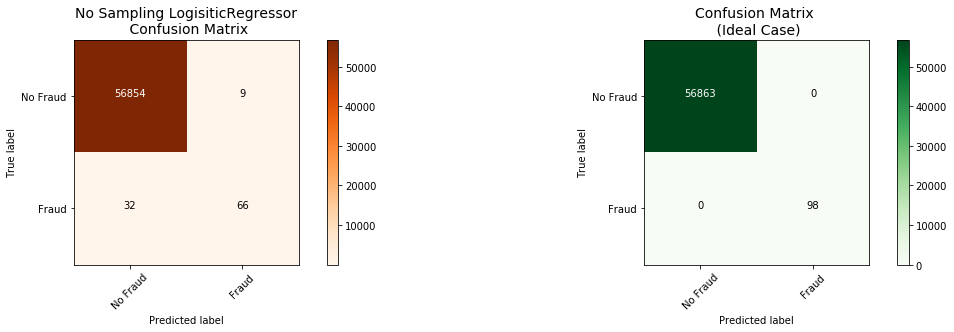

In [16]:
fraud_predictions = tune_the_estimator(estimator=classifiers_for_tune["LogisiticRegression"], params=log_reg_params,Xsm_train = Xsm_train,ysm_train = ysm_train, 
                      X_test = original_Xtest, y_test = original_ytest)

plot_confusion_matrx(original_ytest,fraud_predictions, name="LogisiticRegressor")

## Neural Network

In [17]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [18]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 182276 samples, validate on 45570 samples
Epoch 1/20
 - 1s - loss: 0.0401 - accuracy: 0.9900 - val_loss: 0.0053 - val_accuracy: 0.9993
Epoch 2/20
 - 1s - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9995
Epoch 3/20
 - 1s - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 4/20
 - 1s - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 5/20
 - 1s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 6/20
 - 1s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 7/20
 - 1s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 8/20
 - 1s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 9/20
 - 1s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 10/20
 - 1s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 11/20
 - 1s 

In [20]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [21]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
Confusion matrix, without normalization


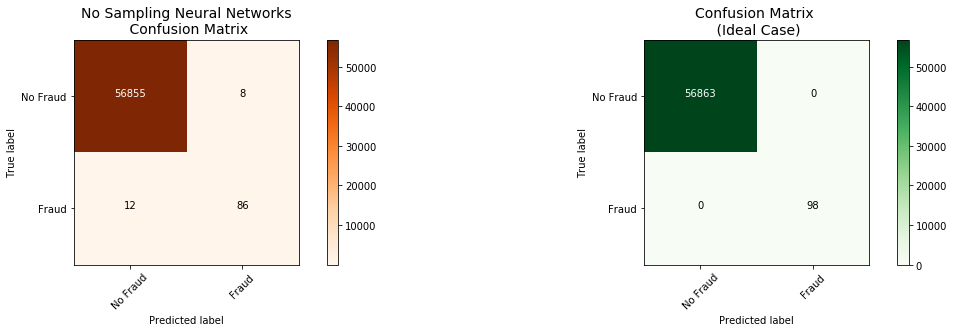

In [22]:
plot_confusion_matrx(original_ytest,oversample_fraud_predictions, name = "Neural Networks")

In [23]:
print(original_Xtest.shape)
# type(Xsm_train)
print(Xsm_train.shape)
print(pd.DataFrame(ysm_train)[0].value_counts())

print(pd.DataFrame(original_ytest)[0].value_counts())

(56961, 30)
(227846, 30)
0    227452
1       394
Name: 0, dtype: int64
0    56863
1       98
Name: 0, dtype: int64


## Random Forest

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.88      0.91        98

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.97      0.94      0.95     56961
weighted avg       1.00      1.00      1.00     56961

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_sample

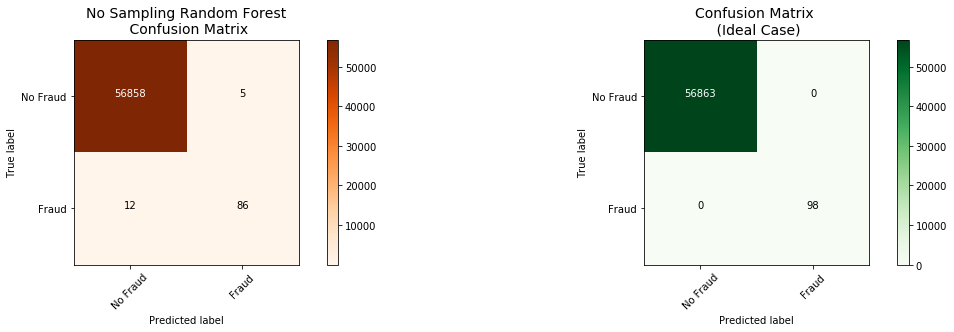

In [24]:
fraud_predictions = tune_the_estimator(estimator=classifiers_for_tune["Random Forest"], params=random_forest_parameters,Xsm_train = Xsm_train,ysm_train = ysm_train, 
                      X_test = original_Xtest, y_test = original_ytest)

plot_confusion_matrx(original_ytest,fraud_predictions, name = "Random Forest")

## XGBoost Classifier

In [25]:
# fraud_predictions = tune_the_estimator(estimator=classifiers_for_tune["xGBClassifier"], params=xgb_params,Xsm_train = Xsm_train,ysm_train = ysm_train, 
#                       X_test = original_Xtest, y_test = original_ytest)


# plot_confusion_matrx(original_ytest,fraud_predictions, name = "XGBoost")

##  Linear SVC

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   51.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   56.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   56.2s finished


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.85      0.82      0.83        98

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.93      0.91      0.92     56961
weighted avg       1.00      1.00      1.00     56961

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
---------------------------------------------Test Performance---------------------------------------------
Recall Score: 0.82 
Precision Score: 0.85
F1 Score: 0.83
Accuracy Score: 1.00 

Confusion matrix, without normalization
Confusion matrix, wi

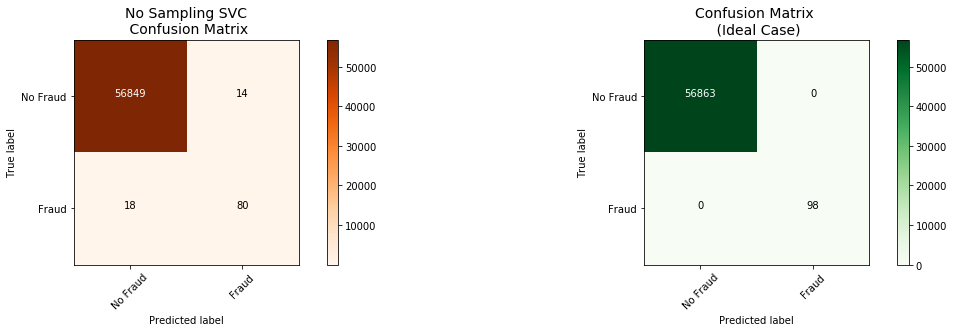

In [26]:
fraud_predictions = tune_the_estimator(estimator=classifiers_for_tune["SVC"], params=svc_params,Xsm_train = Xsm_train,ysm_train = ysm_train, 
                      X_test = original_Xtest, y_test = original_ytest)

plot_confusion_matrx(original_ytest,fraud_predictions, name = "SVC")

## Decsion tree

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    4.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    7.2s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.80      0.81        98

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.91      0.90      0.91     56961
weighted avg       1.00      1.00      1.00     56961

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
        

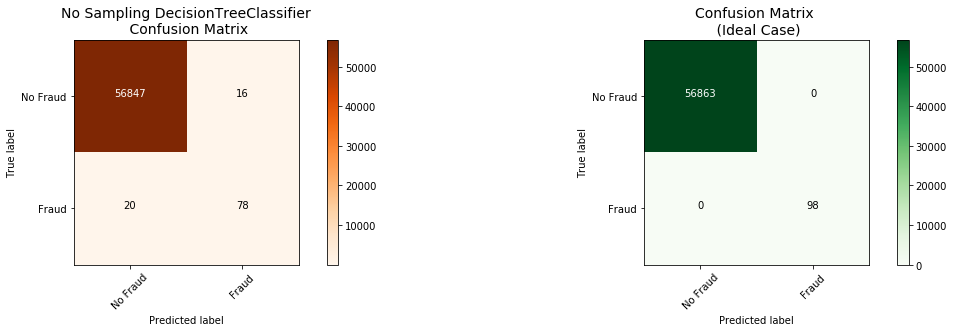

In [27]:
fraud_predictions = tune_the_estimator(estimator=classifiers_for_tune["DecisionTreeClassifier"], params=tree_params,Xsm_train = Xsm_train,ysm_train = ysm_train, 
                      X_test = original_Xtest, y_test = original_ytest)


plot_confusion_matrx(original_ytest,fraud_predictions, name = "DecisionTreeClassifier")




## KNN

In [ ]:
fraud_predictions = tune_the_estimator(estimator=classifiers_for_tune["KNearest"], params=knears_params,Xsm_train = Xsm_train,ysm_train = ysm_train, 
                      X_test = original_Xtest, y_test = original_ytest)

plot_confusion_matrx(original_ytest,fraud_predictions,name="KNN")

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
